In [ ]:
from google.cloud import bigquery
import operator
import networkx as nx
from nltk.util import ngrams
from nltk import FreqDist
import matplotlib.pyplot as plt

In [ ]:
G = nx.Graph()
client = bigquery.Client.from_service_account_json(
        'My Project-c23185ac100b.json')
client.project

In [3]:
query_word = "operating-system"

In [4]:
query = """
        SELECT tags
        FROM `bigquery-public-data.stackoverflow.posts_questions`
        where  tags like @a
        limit 100000
        """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)
results = query_job.result()

bigrams = []
gram = 2
for row in results:
    token = row.tags.split('|')
    bigram = list(ngrams(token,gram))
    bigrams.extend(bigram)
fdist=FreqDist(bigrams)
print(fdist.most_common(30))
associated_words = []
for comb in fdist.most_common(30):
    if query_word in comb[0]:
        associated_words.append(comb[0][comb[0].index(query_word) - 1])
        

[(('linux', 'operating-system'), 514), (('c', 'operating-system'), 490), (('operating-system', 'kernel'), 459), (('process', 'operating-system'), 432), (('c', 'linux'), 340), (('assembly', 'operating-system'), 335), (('memory-management', 'operating-system'), 328), (('multithreading', 'operating-system'), 312), (('linux-kernel', 'operating-system'), 286), (('unix', 'operating-system'), 264), (('windows', 'operating-system'), 248), (('python', 'operating-system'), 244), (('c++', 'c'), 158), (('macos', 'operating-system'), 155), (('operating-system', 'filesystems'), 154), (('memory', 'operating-system'), 151), (('operating-system', 'fork'), 141), (('operating-system', 'paging'), 131), (('java', 'operating-system'), 129), (('c++', 'operating-system'), 127), (('x86', 'operating-system'), 126), (('operating-system', 'scheduling'), 116), (('operating-system', 'system-calls'), 113), (('operating-system', 'x86'), 112), (('linux', 'unix'), 110), (('linux', 'linux-kernel'), 104), (('file', 'oper

In [5]:
associated_words


['linux',
 'c',
 'kernel',
 'process',
 'assembly',
 'memory-management',
 'multithreading',
 'linux-kernel',
 'unix',
 'windows',
 'python',
 'macos',
 'filesystems',
 'memory',
 'fork',
 'paging',
 'java',
 'c++',
 'x86',
 'scheduling',
 'system-calls',
 'x86',
 'file',
 'android',
 'virtual-memory']

In [6]:
correlation = []
for word in associated_words:
    query = """
        SELECT tags
        FROM `bigquery-public-data.stackoverflow.posts_questions`
        where  tags like @a
        limit 100000
        """
    query_params = [
        bigquery.ScalarQueryParameter(
            'a', 'STRING', "%"+word+"%")
        ]
    job_config = bigquery.QueryJobConfig()
    job_config.query_parameters = query_params
    query_job = client.query(query, job_config=job_config)
    results = query_job.result()
    bigrams = []
    gram = 2
    for row in results:
        token = row.tags.split('|')
        bigram = list(ngrams(token,gram))
        bigrams.extend(bigram)
    fdist=FreqDist(bigrams)
    strong_words_temp = []
    
    for comb in fdist.most_common(20):
        if word in comb[0]:
            strong_words_temp.append(comb[0][comb[0].index(word) - 1]) 
            if comb[0][comb[0].index(word) - 1]  == query_word or (word != comb[0][comb[0].index(word) - 1]) and comb[0][comb[0].index(word) - 1] in associated_words:
                correlation.append(word)
    print(word, strong_words_temp)
print(correlation)

linux ['bash', 'c', 'c++', 'python', 'shell', 'java', 'php', 'ubuntu', 'unix', 'linux-kernel', 'gcc', 'windows', 'sockets', 'apache', 'mysql', 'multithreading', 'android']
c []
kernel ['linux-kernel', 'linux', 'operating-system', 'driver', 'kernel-module', 'linux-device-driver', 'windows']
process ['c#', 'linux']
assembly ['x86', 'c', 'mips', 'gcc', 'arm', 'linux', 'nasm', 'c++', 'x86-64', 'masm', 'arrays', 'x86-16', 'gdb', 'windows']
memory-management ['memory', 'c++', 'memory-leaks', 'objective-c', 'c', 'ios', 'pointers', 'java', 'linux', 'android', 'garbage-collection', 'malloc', 'iphone', 'arrays', 'linux-kernel', 'c#']
multithreading ['java', 'c#', 'c++', 'android', 'python', '.net', 'c', 'concurrency', 'sockets', 'linux', 'c++11', 'wpf', 'thread-safety', 'asynchronous', 'pthreads', 'qt', 'synchronization', 'swing']
linux-kernel ['linux', 'linux-device-driver', 'kernel', 'c', 'kernel-module', 'memory-management', 'arm', 'operating-system', 'embedded-linux', 'android', 'driver', 'a

In [7]:
set(correlation)

{'android',
 'assembly',
 'c++',
 'file',
 'filesystems',
 'fork',
 'java',
 'kernel',
 'linux',
 'linux-kernel',
 'macos',
 'memory',
 'memory-management',
 'multithreading',
 'paging',
 'process',
 'python',
 'scheduling',
 'system-calls',
 'unix',
 'virtual-memory',
 'windows',
 'x86'}

In [8]:
# take these strong words and then use the with initial word and use them together to find one bigger ngram.
most_frequent_3_comb = {}
for word in set(correlation):
    query = """
        SELECT tags
        FROM `bigquery-public-data.stackoverflow.posts_questions`
        where  tags like @a and tags like @b
        limit 1000000
        """
    query_params = [
        bigquery.ScalarQueryParameter(
            'a', 'STRING', "%"+word+"%"),
        bigquery.ScalarQueryParameter(
            'b', 'STRING', "%"+query_word+"%")
        ]
    job_config = bigquery.QueryJobConfig()
    job_config.query_parameters = query_params
    query_job = client.query(query, job_config=job_config)
    results = query_job.result()
    bigrams = []
    gram = 3
    for row in results:
        token = row.tags.split('|')
        bigram = list(ngrams(token,gram))
        bigrams.extend(bigram)
    fdist=FreqDist(bigrams)
    
    for l in fdist.most_common(5):
        for w in l[0]:
            if w not in set(correlation):
                break
            if w in most_frequent_3_comb:
                most_frequent_3_comb[w] += 1
            else:
                most_frequent_3_comb[w] = 1
print(most_frequent_3_comb)
    

{'process': 10, 'linux': 22, 'windows': 12, 'python': 8, 'c++': 5, 'memory-management': 13, 'memory': 5, 'assembly': 7, 'x86': 4, 'linux-kernel': 8, 'macos': 4, 'unix': 7, 'file': 6, 'multithreading': 7, 'java': 7, 'android': 6}


In [9]:
most_frequent_comb = sorted(most_frequent_3_comb.items(), key=operator.itemgetter(1), reverse=True)[0][0]

In [10]:
most_frequent_3_comb

{'android': 6,
 'assembly': 7,
 'c++': 5,
 'file': 6,
 'java': 7,
 'linux': 22,
 'linux-kernel': 8,
 'macos': 4,
 'memory': 5,
 'memory-management': 13,
 'multithreading': 7,
 'process': 10,
 'python': 8,
 'unix': 7,
 'windows': 12,
 'x86': 4}

In [11]:
# i can obviosuly go directly but then that would not be the right way to navigate to that tag. I have to find what is the
# right link to get to that word that actually makes sense. for example data structure, tree, binary-search-tree would be 
# right link rather than data structure, java, binary-search-tree

# I can get to binary search tree faster thru tree than going thru graph. 

In [12]:
query = """
    SELECT tags
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a and tags like @b
    limit 1000000
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+most_frequent_comb+"%"),
    bigquery.ScalarQueryParameter(
        'b', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)
results = query_job.result()
bigrams = []
gram = 3
for row in results:
    token = row.tags.split('|')
    bigram = list(ngrams(token,gram))
    bigrams.extend(bigram)
fdist=FreqDist(bigrams)

In [13]:
fdist.most_common(10)
# what if all of them have the same score and some of them contains both the words then which word do you choose? 

[(('c', 'linux', 'operating-system'), 184),
 (('linux', 'linux-kernel', 'operating-system'), 102),
 (('linux', 'unix', 'operating-system'), 81),
 (('linux-kernel', 'operating-system', 'kernel'), 65),
 (('linux', 'operating-system', 'kernel'), 44),
 (('c', 'linux', 'unix'), 42),
 (('linux', 'windows', 'operating-system'), 38),
 (('linux', 'process', 'operating-system'), 37),
 (('linux', 'operating-system', 'linux-kernel'), 34),
 (('c++', 'c', 'linux'), 32)]

In [14]:
other_comb_word = [x for x in fdist.most_common(5)[0][0] if x not in [most_frequent_comb, query_word]][0]
other_comb_word

'c'

In [15]:
query = """
    SELECT tags
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a and tags like @b and tags like @c
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+other_comb_word+"%"),
    bigquery.ScalarQueryParameter(
        'b', 'STRING', "%"+most_frequent_comb+"%"),
    bigquery.ScalarQueryParameter(
        'c', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)
results = query_job.result()
bigrams = []
gram = 4
for row in results:
    token = row.tags.split('|')
    bigram = list(ngrams(token,gram))
    bigrams.extend(bigram)
fdist=FreqDist(bigrams)

In [16]:
fdist.most_common(5)

[(('c', 'linux', 'unix', 'operating-system'), 37),
 (('c', 'linux', 'linux-kernel', 'operating-system'), 31),
 (('c++', 'c', 'linux', 'operating-system'), 17),
 (('c', 'linux', 'operating-system', 'fork'), 16),
 (('c', 'linux', 'operating-system', 'system-calls'), 14)]

In [17]:
query = """
    SELECT title, score
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a and tags like @b and tags like @c
    order by score desc
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+other_comb_word+"%"),
    bigquery.ScalarQueryParameter(
        'b', 'STRING', "%"+most_frequent_comb+"%"),
    bigquery.ScalarQueryParameter(
        'c', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)

In [18]:
results = query_job.result()
for row in results:
    print(row.title, row.score)

What Languages are Windows, Mac OS X and Linux written in? 207
Why is Linux called a monolithic kernel? 174
PHP script - detect whether running under linux or Windows? 114
Spinlock versus Semaphore 98
Locking Executing Files: Windows does, Linux doesn't. Why? 75
dup2 / dup - why would I need to duplicate a file descriptor? 60
Maximum number of processes in linux 54
Check the open FD limit for a given process in Linux 49
Time waste of execv() and fork() 42
Who decides the sizeof any datatype or structure (depending on 32 bit or 64 bit)? 41
What parts of Linux kernel can I read for fun? 36
Is OSX a POSIX OS? 36
Why are "Executable files" operating system dependent? 35
How closely are Mac OS X and BSD related? 35
Windows CE vs Embedded Linux 32
stdout thread-safe in C on Linux? 32
Is it true that fork() calls clone() internally? 31
Why is memory allocation for processes slow and can it be faster? 26
Convert physical address to virtual in Linux and read its content 24
Does Linux use x86 CP

Linux system does not allow creation of sockets because of "Too many open files" *even after a reboot* 2
Shell seems to recognize commands but doesn't execute them 2
Bare bones OS kernel programming 2
How the OS handles python and subprocesses of a python script...? 2
Processors and virtual/physical addresses 2
Data is not written into /proc file 2
Pushing code towards kernel or user space, for performance reasons? 2
Adding a new system call to linux kernel doesn't seem to work 2
linux kernel code ">>" operator 2
ARM - What are the differences in the context switch handling, if IRQ happens in USR mode vs SVC mode? 2
How does an application code talk to the kernel's code? 2
process exit and impact on threads 2
size of pointer is always equal to size of int in C compiler . Is it correct? 2
Multiple child creation with fork() in Linux 2
Determine state of a process 2
Is there any way to excute a command as a specific user in Python? 2
What is the difference between ps and ps -e command in

In [19]:
query = """
    SELECT tags, title
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a 
    order by score desc
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)

In [ ]:
results = query_job.result()
for row in results:
    print(row.tags, row.title)

In [21]:
# there are many ways to miss the most important questions just because there was no tag associated with it. 
# This way I might miss many of the important questions on 2-3-4 trees. 

In [22]:
query = """
    SELECT tag_name, count
    FROM `bigquery-public-data.stackoverflow.tags`
    where tag_name like "%data-structure%"
    """
nfig = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)

In [23]:
results = query_job.result()


In [24]:
for row in results:
    print(row.tag_name, row.count)

perl-data-structures 397
data-structures 20723


In [25]:
query = """
    SELECT tags
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    """
nfig = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)

In [3]:
import numpy as np
import csv
import os
if not os.path.exists('data.csv'):
    results = query_job.result()
    with open('data.csv', 'w') as myfile:
        wr = csv.writer(myfile)
        for row in results:
            wr.writerow(row.tags.split("|"))

In [45]:
import csv 
import sys #used for passing in the argument
file_name = "data.csv" #filename is argument 1
with open(file_name, 'rU') as f:  #opens PW file
    reader = csv.reader(f)
    data = list(list(rec) for rec in csv.reader(f, delimiter=',')) #reads csv into a list of lists

    

/Users/ankurkothari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'U' mode is deprecated
  after removing the cwd from sys.path.


In [5]:
len(data)

15483377

In [6]:
from gensim.models import Word2Vec

In [16]:
from gensim.models import KeyedVectors
b = KeyedVectors.load("word2vec_model")

In [17]:
b.most_similar([ 'artificial-intelligence'], topn=20)

/Users/ankurkothari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('genetic-algorithm', 0.7181348204612732),
 ('path-finding', 0.6938122510910034),
 ('neural-network', 0.659702479839325),
 ('graph-algorithm', 0.6270614862442017),
 ('depth-first-search', 0.5898061990737915),
 ('graph-theory', 0.5874534845352173),
 ('breadth-first-search', 0.5869895815849304),
 ('computer-science', 0.5836610794067383),
 ('pseudocode', 0.5804481506347656),
 ('bayesian', 0.5632973909378052),
 ('mathematical-optimization', 0.5631980895996094),
 ('machine-learning', 0.5628211498260498),
 ('prediction', 0.550203800201416),
 ('classification', 0.5404967069625854),
 ('probability', 0.5374963879585266),
 ('nlp', 0.5372757315635681),
 ('algorithm', 0.529630184173584),
 ('decision-tree', 0.5294957756996155),
 ('game-physics', 0.5257804989814758),
 ('data-mining', 0.5222604274749756)]

In [101]:
X = b[b.wv.vocab]

/Users/ankurkothari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [103]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [106]:
import pandas as pd

df = pd.DataFrame(X_tsne, index=words, columns=['x', 'y'])

In [92]:
from sklearn.decomposition import TruncatedSVD

In [109]:
plt.plot(df)

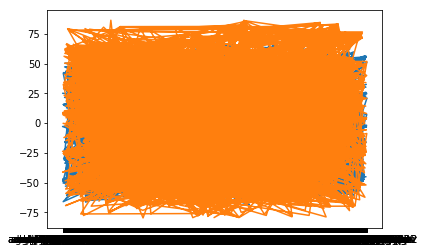

In [110]:
plt.show()

In [116]:
docs

['vba web-scraping xmlhttprequest',
 'android python',
 'php mysql database insert',
 'oracle timeout prepared-statement oci',
 'jquery jquery-animate',
 'node.js socket.io',
 'javascript angularjs twitter-bootstrap karma-jasmine',
 'php arrays sorting alphabetical-sort',
 'java debugging jboss',
 'c++ mysql',
 'c# .net list',
 'java jboss jboss-eap-6',
 'neo4j cypher',
 'php soap wsdl xsd',
 'php codeigniter',
 'c++ if-statement vector compiler-errors std',
 'html css3 multiple-columns',
 'selenium webdriver junit4 junit3',
 'flash builder',
 'laravel laravel-5 laravel-blade',
 'asp.net-web-api web-hosting self-hosting',
 'c arrays pointers segmentation-fault c-strings',
 'vb.net ms-access',
 'phpmailer',
 'javascript php jquery ajax',
 'firefox-addon',
 'matlab image-processing',
 'nativescript angular2-nativescript',
 'php mysql ajax',
 'json node.js frontend backend',
 'php string-concatenation',
 'redmine',
 'android ios user-interface controller',
 'python-3.x for-loop split',
 '

In [ ]:
from gensim import corpora, models, similarities
from itertools import chain
import gensim
documents = docs
texts = data

# remove words that appear only once
all_tokens = sum(texts, [])
tokens_once = set(word for word in set(all_tokens) if all_tokens.count(word) == 1)
texts = [[word for word in text if word not in tokens_once] for text in texts]

# Create Dictionary.
id2word = corpora.Dictionary(texts)
# Creates the Bag of Word corpus.
mm = [id2word.doc2bow(text) for text in texts]

# Trains the LDA models.
lda = models.ldamodel.LdaModel(corpus=mm, id2word=id2word, num_topics=3, \
                               update_every=1, chunksize=10000, passes=1)

# Prints the topics.
for top in lda.print_topics():
  print(top)
print

In [ ]:
# Assigns the topics to the documents in corpus
lda_corpus = lda[mm]

# Find the threshold, let's set the threshold to be 1/#clusters,
# To prove that the threshold is sane, we average the sum of all probabilities:
scores = list(chain(*[[score for topic_id,score in topic] \
                      for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores)/len(scores)
print threshold
print

cluster1 = [j for i,j in zip(lda_corpus,documents) if i[0][1] > threshold]
cluster2 = [j for i,j in zip(lda_corpus,documents) if i[1][1] > threshold]
cluster3 = [j for i,j in zip(lda_corpus,documents) if i[2][1] > threshold]

print cluster1
print cluster2
print cluster3

In [93]:
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

import logging
from optparse import OptionParser
import sys
from time import time
t0 = time()
svd = TruncatedSVD(5)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd)

X = lsa.fit_transform(X)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

print()

done in 0.028146s
Explained variance of the SVD step: 26%



In [ ]:
# Assigns the topics to the documents in corpus
lda_corpus = lda[mm]

# Find the threshold, let's set the threshold to be 1/#clusters,
# To prove that the threshold is sane, we average the sum of all probabilities:
scores = list(chain(*[[score for topic_id,score in topic] \
                      for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores)/len(scores)
print threshold
print

cluster1 = [j for i,j in zip(lda_corpus,documents) if i[0][1] > threshold]
cluster2 = [j for i,j in zip(lda_corpus,documents) if i[1][1] > threshold]
cluster3 = [j for i,j in zip(lda_corpus,documents) if i[2][1] > threshold]

print cluster1
print cluster2
print cluster3

In [94]:
X.shape

(3979, 5)

In [95]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [96]:
kmeans.cluster_centers_

array([[ 6.40474916e-01, -1.75693130e+00,  2.92434454e+00,
         1.56111717e+00,  5.04906178e+00],
       [ 2.36960030e+00,  4.91315305e-01, -6.39069140e-01,
         2.49454641e+00, -1.31546175e+00],
       [-4.90208507e-01, -3.18682003e+00, -2.15615702e+00,
        -7.72579134e-01, -5.05313516e-01],
       [-2.17126465e+00, -6.15603209e-01,  1.58155823e+00,
         2.16830909e-01, -3.79778743e-01],
       [ 2.37872863e+00,  4.93699253e-01, -1.05910015e+00,
        -1.35830545e+00, -1.01907146e+00],
       [-1.49927473e+00,  1.14147925e+00, -2.57797265e+00,
         1.04663408e+00,  3.46404696e+00],
       [-6.86684072e-01,  4.46242619e+00, -2.59826124e-01,
        -1.06534719e+00, -1.35817516e+00],
       [ 2.78702188e+00, -1.27755988e+00, -1.07053137e+00,
         5.84892184e-02,  6.60071611e-01],
       [-3.74006844e+00,  5.99339128e-01, -7.06973374e-01,
        -5.64297438e-01, -2.04474181e-01],
       [-3.12159252e+00, -2.59119034e+00,  2.31655169e+00,
        -1.11895525e+00

In [97]:
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)

In [98]:
order_centroids = original_space_centroids.argsort()[:, ::-1]


In [99]:
order_centroids

array([[197,  47,  36, ...,  53,  69,  52],
       [ 56, 135, 144, ...,  23, 197,   6],
       [162, 149,  76, ..., 129, 153, 174],
       ...,
       [174,  21, 153, ..., 168, 162,  76],
       [ 74,  16, 197, ..., 159,  28,   1],
       [  6,  25,  96, ..., 129,  95, 135]])

In [100]:
words = list(b.wv.vocab)
for i in range(100):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i]:
            print(' %s' % words[ind], end='')
        print()

Cluster 0: build laravel vector class javascript getline wordpress process assembly android ios6 boolean ios multithreading request hibernate stored-procedures button field symfony .net aframe types output string-concatenation backend ms-access merge android-manifest rxjs c++ label ajax asp.net-identity prepared-statement grails neo4j github wcf web-hosting arrays jruby sql-delete mouseover reactjs oracle nsurl json macos centos lotus-domino queue arm python ionic2 selenium html karma-jasmine flash performance std xcode matlab database templates checkbox datetime webdriver statistics mips xamarin angularjs wpf xquery image-processing web-applications google-play for-loop php menu virtualenv artificial-intelligence sql-server nullpointerexception android-camera multiple-columns compiler-errors azure-webjobs python-3.x swing whitespace xsd magento android-edittext redux zxing c# spinner url-routing parameter-passing garbage-collection asp.net-web-api postgresql constraints vba c debuggin

Cluster 6: sorting sqlite twitter-bootstrap nativescript garbage-collection debugging entity-framework-4.1 web-scraping mysql statsmodels multiple-columns jquery opacity layout frontend segmentation-fault controller jboss oracle12c variables button oauth bamboo mips segue firefox-addon pointers swing ruby python typescript function android-fragments maven-2 r php url-routing genetic-algorithm select session image-processing builder virtualenv cypher if-statement merge artificial-intelligence ionic3 insert xpages split visual-studio-code swift dynamic-sql xamarin visual-studio node.js matplotlib linux-kernel grails time-series asp.net-mvc git zxing tsql css3 soap list vb.net vba redmine timeout arrays junit4 xquery apache architecture sql wpf plsql ajax google-play exception datetime web-applications for-loop nsurl menu handle sql-delete postgresql std xmlhttprequest azure nullpointerexception c# user-interface oracle pip ios6 webdriver string-concatenation constraints parameter-passing

Cluster 12: swift matlab controller segmentation-fault xml jruby codeigniter .htaccess class flash ruby sorting android c python spinner layout compiler-errors tsql vb.net json xamarin gradle debugging conditional plot insert bamboo jquery web-hosting reverse-engineering redux android-fragments handle reactjs sql time-series z-index xcode ajax socket.io counter .net java url-routing angularjs sql-server php wordpress merge asp.net field exception css3 ios neural-network dynamic-sql if-statement pip jboss opacity string-concatenation segue oracle git karma-jasmine asp.net-mvc backend build cypher button web-applications plsql user-interface android-camera parameter-passing std oracle12c database intellij-idea builder xsd pointers node.js azure-webjobs laravel-5 frontend architecture mouseover soap prototypejs javascript ionic3 android-manifest lotus-domino session r entity-framework-4.1 jquery-animate azure laravel wcf constraints getline xpages xmlhttprequest junit4 stored-procedures s

Cluster 17: build class android wordpress matlab jruby javascript getline ios flash reactjs stored-procedures redux process laravel .net backend field codeigniter c string-concatenation angularjs web-hosting json compiler-errors aframe gradle xcode oracle plot ajax assembly button mouseover request spinner database wcf asp.net-identity github python karma-jasmine ios6 lotus-domino arm hibernate .htaccess merge vector android-manifest azure-webjobs xsd swift std xamarin tsql macos types centos rxjs socket.io php templates ruby neural-network html sql-server parameter-passing grails performance android-camera url-routing counter xml reverse-engineering ms-access debugging output laravel-5 sql queue multithreading pip statistics z-index boolean handle arrays web-applications jquery-animate android-edittext nsurl magento wpf java prepared-statement python-3.x nullpointerexception conditional xquery asp.net webdriver neo4j asp.net-web-api css3 constraints vb.net azure asp.net-mvc prototypej

Cluster 27: vector wordpress android-manifest asp.net-identity laravel neo4j stored-procedures selenium xcode android web-hosting getline wsdl json label matlab output javascript sql-server matplotlib types sql-delete backend checkbox web-scraping build whitespace hashmap boolean merge mouseover css github user-interface rxjs neural-network html field socket.io flash wcf symfony .htaccess assembly process phpmailer ios ajax lotus-domino .net garbage-collection counter web-applications queue karma-jasmine intellij-idea xmlhttprequest spinner ms-access url-rewriting css3 macos prepared-statement centos codeigniter ios6 android-edittext list hibernate arm time-series request redux r menu constraints multiple-columns jquery-animate python datetime class xamarin function conditional c++ compiler-errors xpages maven-2 android-camera image-processing arrays sharepoint-2013 nsurl linux-kernel java postgresql xsd multithreading templates junit4 c# webdriver magento nullpointerexception dynamic-

Cluster 33: phpmailer std url-rewriting android-manifest xml output javascript ionic2 nsurl performance multithreading process for-loop centos queue matplotlib label whitespace symfony ios5 menu neural-network jquery-animate webdriver lotus-domino boolean wsdl class soap swing karma-jasmine magento html apache counter redmine xamarin intellij-idea asp.net-web-api virtualenv android-camera bamboo arrays asp.net-identity parameter-passing templates backend artificial-intelligence string-concatenation checkbox arm session hashmap wcf visual-studio-code sqlite linux-kernel prepared-statement sql-delete image-processing getline pip statistics vector request wpf asp.net visual-studio python-3.x grails azure-webjobs c socket.io google-play maven-2 merge types json xmlhttprequest neo4j character select vba redux gradle database github c# mouseover insert python architecture web-applications r vb.net conditional garbage-collection function builder stored-procedures time-series ios firefox-addon

Cluster 38: sorting python merge xamarin button class sqlite debugging controller swift segmentation-fault ajax ruby bamboo php layout jruby json jboss std web-scraping jquery r grails url-routing nsurl string-concatenation matplotlib twitter-bootstrap arrays statsmodels android-manifest insert oracle12c time-series entity-framework-4.1 multiple-columns web-applications soap swing garbage-collection tsql xml maven-2 builder opacity sql image-processing field android-fragments cypher matlab oracle menu laravel web-hosting segue .net session frontend sql-server spinner visual-studio-code asp.net-mvc css3 multithreading virtualenv karma-jasmine vba handle vector redmine vb.net flash for-loop performance xpages firefox-addon nativescript wpf node.js android visual-studio javascript pip junit4 webdriver xquery ios function artificial-intelligence dynamic-sql if-statement android-camera mysql parameter-passing ios6 git mips pointers conditional queue compiler-errors java aframe counter apach

Cluster 44: controller matlab segmentation-fault swift xml .htaccess json codeigniter flash conditional time-series spinner xcode android web-hosting python sql-server ruby xamarin socket.io counter pointers sorting layout neural-network merge jruby opacity compiler-errors android-fragments insert bamboo user-interface wordpress java reverse-engineering android-manifest handle css3 web-scraping intellij-idea xmlhttprequest matplotlib gradle ajax plsql c class dynamic-sql z-index sql ionic3 web-applications asp.net cypher git vb.net if-statement tsql karma-jasmine redux r jquery soap wsdl backend .net xpages field node.js plot list whitespace jboss linux-kernel asp.net-identity android-camera mouseover pip jquery-animate ios oracle12c lotus-domino constraints hashmap laravel neo4j debugging exception css prototypejs session asp.net-mvc twitter-bootstrap angularjs junit4 php wcf url-routing phpmailer architecture visual-studio-code xsd frontend javascript android-edittext stored-procedur

Cluster 50: std swing xml sqlite phpmailer bamboo nsurl ionic2 for-loop url-rewriting performance multithreading soap redmine matplotlib ios5 segue session menu xamarin virtualenv apache webdriver statsmodels android-manifest artificial-intelligence vb.net queue asp.net-web-api parameter-passing visual-studio-code builder visual-studio insert wpf class arrays select google-play linux-kernel architecture whitespace jquery-animate firefox-addon image-processing variables symfony oracle12c javascript grails process maven-2 pip output twitter-bootstrap php string-concatenation neural-network vba karma-jasmine android-camera python centos jquery magento lotus-domino counter asp.net-mvc timeout intellij-idea exception entity-framework-4.1 garbage-collection label ionic3 r function button jboss pointers statistics cypher merge wsdl opacity time-series asp.net xquery frontend layout laravel-5 azure character c xmlhttprequest sorting segmentation-fault prepared-statement url-routing azure-webjo

Cluster 56: hashmap url-rewriting phpmailer reverse-engineering selenium redux wsdl css xmlhttprequest stored-procedures socket.io arm list sharepoint-2013 .htaccess intellij-idea types pointers asp.net prototypejs asp.net-identity character html centos jquery-animate neural-network plsql angular magento c# xsd user-interface output xcode ionic3 conditional haskell android-edittext github whitespace boolean counter c++ rxjs templates linux-kernel codeigniter timeout xml label mouseover wordpress checkbox python-3.x ios5 java architecture getline sql-delete neo4j plot z-index macos gradle azure-webjobs split sql-server angularjs constraints git oauth matlab select xpages if-statement opacity postgresql nullpointerexception wcf dynamic-sql backend lotus-domino flash exception c function apache hibernate spinner time-series compiler-errors matplotlib ionic2 handle azure typescript datetime database android-camera css3 cypher web-hosting node.js zxing queue android-fragments asp.net-web-ap

Cluster 61: android-manifest vector json wordpress matlab merge matplotlib android xcode web-hosting sql-server laravel neo4j web-scraping asp.net-identity python wsdl xamarin javascript flash neural-network whitespace ajax backend xml counter .htaccess time-series web-applications user-interface class checkbox socket.io getline spinner karma-jasmine field stored-procedures codeigniter controller conditional mouseover r label .net intellij-idea swift xmlhttprequest lotus-domino css3 phpmailer queue segmentation-fault ios output wcf selenium garbage-collection css build menu process hashmap nsurl soap pointers java xpages maven-2 html jruby github sql-delete android-camera compiler-errors linux-kernel arrays assembly handle jquery-animate constraints multiple-columns symfony image-processing function cypher sql ruby ionic3 types plsql prepared-statement list opacity rxjs dynamic-sql gradle android-edittext junit4 node.js performance visual-studio-code macos insert string-concatenation w

Cluster 67: ionic2 swing url-rewriting variables segue google-play timeout ios5 c# haskell mysql asp.net-web-api select std statsmodels phpmailer sqlite architecture artificial-intelligence redmine character magento centos exception vb.net virtualenv for-loop session wpf multithreading parameter-passing c++ laravel-5 apache firefox-addon builder python-3.x genetic-algorithm typescript templates performance boolean entity-framework-4.1 statistics visual-studio nativescript frontend oauth xquery arm symfony webdriver azure bamboo split azure-webjobs aframe asp.net-mvc output jquery-animate vba visual-studio-code jquery oracle12c nsurl asp.net twitter-bootstrap sql-delete angular linux-kernel pip request soap menu function zxing reactjs sharepoint-2013 image-processing label grails ionic3 html plot mips queue hibernate php prepared-statement if-statement url-routing hashmap database insert garbage-collection maven-2 angularjs process plsql types reverse-engineering android-camera pointers

Cluster 73: phpmailer url-rewriting hashmap wsdl xmlhttprequest xml intellij-idea matplotlib whitespace neural-network pointers socket.io asp.net-identity css android-manifest output counter jquery-animate label linux-kernel selenium html reverse-engineering checkbox ionic3 centos conditional neo4j redux asp.net plsql stored-procedures xcode user-interface sql-delete types character boolean .htaccess magento sql-server arm list time-series ios5 queue vector lotus-domino soap sharepoint-2013 function apache c# github android-edittext codeigniter java wordpress mouseover xpages menu backend karma-jasmine opacity getline symfony templates garbage-collection select wcf json android-camera visual-studio-code constraints web-scraping for-loop rxjs javascript maven-2 cypher web-applications architecture flash matlab xsd prototypejs z-index python-3.x gradle timeout performance spinner git segmentation-fault controller webdriver r visual-studio session macos postgresql haskell angular web-host

Cluster 79: redux build stored-procedures arm angularjs reverse-engineering plot reactjs getline xsd hibernate c++ types wordpress prototypejs android c angular templates centos github azure-webjobs rxjs selenium codeigniter haskell request compiler-errors aframe hashmap database gradle ios .htaccess matlab laravel-5 magento flash python-3.x macos boolean nullpointerexception sharepoint-2013 mouseover html process backend asp.net .net android-edittext exception jruby asp.net-identity ms-access ionic2 socket.io statistics split oracle asp.net-web-api ios6 xcode wcf assembly z-index field tsql parameter-passing google-play character jquery-animate azure mysql javascript output vb.net spinner datetime web-hosting timeout lotus-domino class laravel xquery pip string-concatenation architecture wpf css postgresql java handle c# list url-routing constraints dynamic-sql segue asp.net-mvc android-camera neural-network zxing variables conditional karma-jasmine debugging counter genetic-algorithm

Cluster 84: std ionic2 xml class process swing javascript centos performance reactjs c redux parameter-passing asp.net-web-api multithreading vb.net magento segue string-concatenation azure-webjobs jquery-animate arm ios5 nsurl templates output gradle url-rewriting plot laravel-5 google-play phpmailer angularjs lotus-domino jruby wpf redmine webdriver queue aframe pip exception for-loop statistics database build karma-jasmine asp.net python-3.x bamboo neural-network request html oracle haskell android-camera builder architecture codeigniter boolean counter getline backend php session ios menu reverse-engineering grails asp.net-mvc azure soap android-manifest symfony wcf sqlite xquery xamarin statsmodels intellij-idea apache flash insert timeout whitespace arrays stored-procedures button url-routing character github vba variables tsql z-index socket.io label artificial-intelligence xsd mouseover android prepared-statement visual-studio hibernate types hashmap sql virtualenv jquery macos

Cluster 91: url-rewriting output phpmailer boolean label centos android-manifest hashmap asp.net-identity javascript types wsdl stored-procedures html symfony process getline vector whitespace arm sql-delete ionic2 neural-network queue jquery-animate magento neo4j checkbox lotus-domino github backend wordpress matplotlib redux multithreading selenium templates c++ intellij-idea c# ios5 wcf request rxjs performance mouseover css for-loop counter socket.io laravel build karma-jasmine nsurl menu prepared-statement webdriver xml hibernate xmlhttprequest character xcode python-3.x macos android android-edittext apache android-camera std assembly ms-access ios linux-kernel asp.net-web-api statistics azure-webjobs virtualenv asp.net database json soap sharepoint-2013 sql-server xsd garbage-collection reverse-engineering constraints artificial-intelligence image-processing arrays function flash codeigniter select haskell user-interface redmine web-applications gradle maven-2 conditional visual

Cluster 96: reverse-engineering redux .htaccess matlab codeigniter plot prototypejs compiler-errors c angularjs swift controller asp.net flash gradle socket.io xsd vb.net segmentation-fault conditional angular android exception spinner z-index xml hashmap stored-procedures xcode tsql dynamic-sql reactjs java ruby list if-statement android-fragments handle wordpress plsql jruby arm git azure-webjobs web-hosting architecture sharepoint-2013 haskell css3 laravel-5 counter user-interface nullpointerexception layout intellij-idea selenium jquery pointers database android-edittext split neural-network insert sql segue build jquery-animate mouseover xmlhttprequest sql-server opacity pip github azure timeout .net ionic3 css asp.net-mvc node.js getline mysql templates character python-3.x ios time-series backend frontend debugging magento macos url-routing constraints asp.net-identity cypher parameter-passing html rxjs field oracle postgresql android-camera typescript bamboo wcf nativescript js

In [76]:
word_cluster1 = {}
for i, word in enumerate(words):  
    word_cluster1[word] = labels[i]

NameError: name 'words' is not defined

In [113]:
from collections import defaultdict

v1 = defaultdict(list)

for key, value in sorted(word_cluster1.items()):
    v1[value].append(key)

In [114]:
v1

defaultdict(list,
            {0: ['gettext',
              'globalization',
              'internationalization',
              'locale',
              'localization',
              'multilanguage',
              'multilingual',
              'translation'],
             1: ['arrays',
              'binary-search',
              'binary-search-tree',
              'binary-tree',
              'bubble-sort',
              'combinations',
              'do-while',
              'dynamic-programming',
              'fibonacci',
              'for-loop',
              'indexoutofboundsexception',
              'infinite-loop',
              'iteration',
              'iterator',
              'linked-list',
              'list',
              'loops',
              'mergesort',
              'multidimensional-array',
              'nested-lists',
              'nested-loops',
              'palindrome',
              'permutation',
              'primes',
              'priority-queue',
 

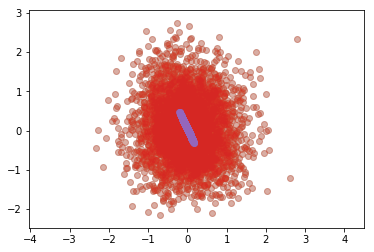

In [67]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');
plt.show()

In [59]:
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [63]:
print(pca.explained_variance_)

[5.6296773 4.897125 ]


In [1410]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
 

# generate the linkage matrix
Z = linkage(X, 'ward')


In [1412]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.2384684021301623

In [1381]:
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',

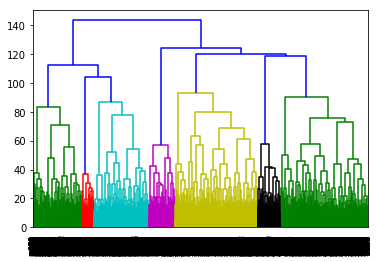

In [1382]:
plt.show()

array([996.        , 997.        ,   2.15974402,   2.        ])

In [1428]:
b.wv.

{'asp.net': <gensim.models.keyedvectors.Vocab at 0x24c50cb70>,
 'code-behind': <gensim.models.keyedvectors.Vocab at 0x24c50cbe0>,
 'javascript': <gensim.models.keyedvectors.Vocab at 0x24c50cc18>,
 'ajax': <gensim.models.keyedvectors.Vocab at 0x24c50cba8>,
 'c++': <gensim.models.keyedvectors.Vocab at 0x24c50c7b8>,
 'linux': <gensim.models.keyedvectors.Vocab at 0x24c50c748>,
 'php': <gensim.models.keyedvectors.Vocab at 0x24c50c6a0>,
 'mysql': <gensim.models.keyedvectors.Vocab at 0x24c50c7f0>,
 'jquery': <gensim.models.keyedvectors.Vocab at 0x24c50cc50>,
 'html': <gensim.models.keyedvectors.Vocab at 0x24c50cc88>,
 'css3': <gensim.models.keyedvectors.Vocab at 0x24c50ccc0>,
 'css-animations': <gensim.models.keyedvectors.Vocab at 0x24c50ccf8>,
 'angularjs': <gensim.models.keyedvectors.Vocab at 0x24c50cd30>,
 'angular': <gensim.models.keyedvectors.Vocab at 0x24c50cd68>,
 'protractor': <gensim.models.keyedvectors.Vocab at 0x24c50cda0>,
 'python': <gensim.models.keyedvectors.Vocab at 0x24c50cdd

In [1427]:
len(Z)

3978

In [1418]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

NameError: name 'fancy_dendrogram' is not defined

In [1419]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

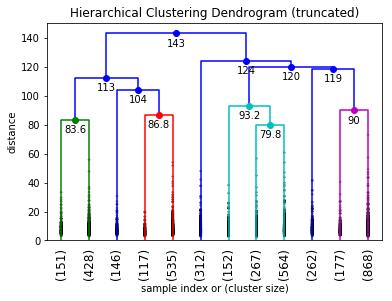

In [1420]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

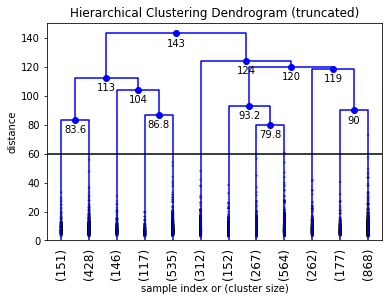

In [1421]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=60,  # plot a horizontal cut-off line
)
plt.show()

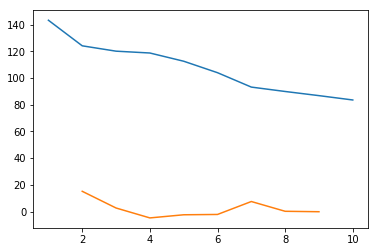

clusters: 2


In [1423]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print( "clusters:", k)

In [ ]:
#as the reputation increases, find out the tags of the questions being asked by these users. Also find out the answers
# frequency with which they ask question and answer. and what is the general trend of the scores of these answers. 
# is there a trend that we see? So that we can use thes trend and then predict what type of questions to show to the user. 
# for him to answer. Or just read with the answer of these questions. 